In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from IPython.core.debugger import set_trace
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Download Train and Test data

In [4]:
train = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])) 
test = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])) 

## Use DataLoader for feeding data in batches

In [5]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [6]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [7]:
x, y = data[0][0], data[1][0]

In [8]:
x.size()

torch.Size([1, 28, 28])

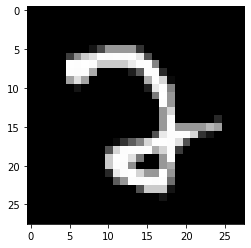

In [9]:
plt.imshow(x.reshape(28,28), cmap='gray')

## Data is Balanced or Not

In [10]:
count_total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for x,y in trainset:
    for i in y:
        counter_dict[int(i)] += 1
        count_total += 1
        
print(counter_dict, count_total)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949} 60000


In [11]:
for label in counter_dict:
    print(f"{label}: {counter_dict[label]/count_total * 100}")

0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


## Building Neural Network Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(320, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool1(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=10, bias=True)
)


In [14]:
xi = torch.rand(1,1,28,28)
# xi = xi.reshape(xi.size(0),-1)
print(net(xi))

tensor([[-2.3745, -2.1024, -2.4551, -2.2556, -2.3689, -2.3306, -2.2837, -2.2584,
         -2.3210, -2.3156]], grad_fn=<LogSoftmaxBackward>)


## Using GPU

In [22]:
# net = net.to(DEVICE)

## Loss and Optimizer

In [16]:
import torch.optim as optim

In [17]:
# loss_fn = nn.CrossEntropyLoss()
# create a loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [21]:
def fit(model, loss_fn, optimizer, train_dl, valid_dl, n_epochs: int):
    for epoch in range(n_epochs):
        # TRAIN
        model.train()
        for batch_idx, (x, y) in enumerate(train_dl):
#             x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            y_ = model(x)
            loss = loss_fn(y_, y)
            loss.backward()
            optimizer.step()
            
            # Statistics
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(x), len(train_dl.dataset),
                               100. * batch_idx / len(train_dl), loss.data))
            
        # EVAL
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for x, y in valid_dl:
#                 x, y = x.to(DEVICE), y.to(DEVICE)
                y_ = model(x)
                loss = loss_fn(y_, y)
                # sum up batch loss
                test_loss += loss_fn(y_, y).data
                pred = y_.data.max(1)[1]  # get the index of the max log-probability
                correct += pred.eq(y.data).sum()
    
        # Statistics  
        test_loss /= len(valid_dl.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(valid_dl.dataset),
                100. * correct / len(valid_dl.dataset)))

In [20]:
fit(net, criterion, optimizer, trainset, testset, 2)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.261497
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.203429
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.715218
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.628828
Train Epoch: 0 [40000/60000 (67%)]	Loss: 1.071762
Train Epoch: 0 [50000/60000 (83%)]	Loss: 1.022715

Test set: Average loss: 0.0347, Accuracy: 8985/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.208404
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.401857
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.889744
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.198373
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.050732
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.040188

Test set: Average loss: 0.0227, Accuracy: 9332/10000 (93%)



In [37]:
# run the main training loop
net.train()
for epoch in range(2):
    for batch_idx, (data, target) in enumerate(trainset):
        optimizer.zero_grad()
        net_out = net(data)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(trainset.dataset),
                           100. * batch_idx / len(trainset), loss.data))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.112935
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.338182


KeyboardInterrupt: 

In [38]:
# run a test loop
net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in testset:
        net_out = net(data)
        # sum up batch loss
        test_loss += criterion(net_out, target).data
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).sum()

test_loss /= len(testset.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset.dataset),
        100. * correct / len(testset.dataset)))


Test set: Average loss: 0.0263, Accuracy: 9211/10000 (92%)

